In [37]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn import preprocessing
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors

In [18]:
# create a dataframe to store the information
df = pd.DataFrame(columns=['text', 'relevant'])

handle = open('classify.json')

for line in handle:
    item = json.loads(line)
    if item['isRelevant'] == 0:
        temp = pd.DataFrame([[item['text'], 'notRelevant']], columns=['text', 'relevant'])
    else:
        temp = pd.DataFrame([[item['text'], 'relevant']], columns=['text', 'relevant'])
    df = df.append(temp)
    
handle.close()

print(df.head())

                                                text     relevant
0  destin charger charg normal car 7kw super netw...     relevant
0  thank make frick spaceflight feel normal const...  notRelevant
0             super charger work hard holiday season     relevant
0       egyptian bitch blush vintag tux dilling tuck  notRelevant
0                       angel heaven silk bed fill _  notRelevant


In [33]:
le = preprocessing.LabelEncoder()
le.fit(df['relevant'])
labels = le.transform(df['relevant']) 
df['relevant'] = labels

print(df.head())

                                                text  relevant
0  destin charger charg normal car 7kw super netw...         1
0  thank make frick spaceflight feel normal const...         0
0             super charger work hard holiday season         1
0       egyptian bitch blush vintag tux dilling tuck         0
0                       angel heaven silk bed fill _         0


In [34]:
stemmer = SnowballStemmer("english", ignore_stopwords=True)
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

stemmed_count_vect = StemmedCountVectorizer(stop_words='english')
text_clf_pipe = Pipeline([('vect', stemmed_count_vect),
                     ('tfidf', TfidfTransformer()),
                     ('mnb', MultinomialNB(fit_prior=False)),])

In [39]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

x_train, x_test, y_train, y_test = train_test_split(df['text'], df['relevant'], test_size=0.25)

averageType = "macro"
text_clf = text_clf_pipe.fit(x_train, y_train)
y_pred = text_clf.predict(x_train)
accuracy = accuracy_score(y_train, y_pred)
print("Train Set \nAccuracy: %0.4f" % (accuracy))
recall = recall_score(y_train, y_pred, average=averageType)
print("Recall: %0.4f" % recall)
precision = precision_score(y_train, y_pred, average=averageType)
print("Precision: %0.4f" % precision)
f1 = f1_score(y_train, y_pred, average=averageType)
print("F-Score: %0.4f" % f1)
values_train = accuracy, recall, precision, f1

y_pred = text_clf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nTrain Set \nAccuracy: %0.4f" % (accuracy))
recall = recall_score(y_test, y_pred, average=averageType)
print("Recall: %0.4f" % recall)
precision = precision_score(y_test, y_pred, average=averageType)
print("Precision: %0.4f" % precision)
f1 = f1_score(y_test, y_pred, average=averageType)
print("F-Score: %0.4f" % f1)
values_test = accuracy, recall, precision, f1
values_compiled = np.array([values_train, values_test]).transpose()

Train Set 
Accuracy: 0.9307
Recall: 0.9311
Precision: 0.9280
F-Score: 0.9294

Train Set 
Accuracy: 0.6464
Recall: 0.6420
Precision: 0.6410
F-Score: 0.6414


AttributeError: 'AxesSubplot' object has no attribute 'set_color_cycle'

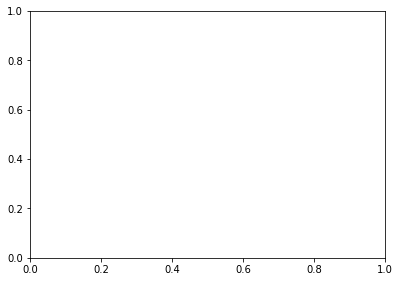

In [40]:
#Plot test set topic values and predicted topic values
NUM_COLORS = 22
cm = plt.get_cmap('gist_ncar')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

allTopics = le.classes_
y_pred = text_clf.predict(x_train)
fig = plt.figure(figsize=(14,10))

trainCategories = list(le.inverse_transform(y_train))
trainCatDict = defaultdict(float)
for topic in allTopics:
    trainCatDict[topic] += 0.00000001
for category in trainCategories:
    trainCatDict[category] += 1

ax1 = fig.add_subplot(2,2,1)
ax1.set_color_cycle([scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
ax1.pie(trainCatDict.values(), startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Train True Topics',fontsize=14)

predCategories = list(le.inverse_transform(y_pred))
predCatDict = defaultdict(float)
for topic in allTopics:
    predCatDict[topic] += 0.00000001
for category in predCategories:
    predCatDict[category] += 1

ax2 = fig.add_subplot(2,2,2)    
ax2.set_color_cycle([scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
ax2.pie(predCatDict.values(), startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title('Train Predicted Topics',fontsize=14)
ax2.legend(allTopics)
y_pred = text_clf.predict(x_test)
testCategories = list(le.inverse_transform(y_test))
testCatDict = defaultdict(int)
for topic in allTopics:
    testCatDict[topic] += 0.00000001
for category in testCategories:
    testCatDict[category] += 1

ax3 = fig.add_subplot(2,2,3)
ax3.set_color_cycle([scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
ax3.pie(testCatDict.values(), startangle=90)
ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax3.set_title('Test True Topics',fontsize=14)

predCategories = list(le.inverse_transform(y_pred))
predCatDict = defaultdict(int)
for topic in allTopics:
    predCatDict[topic] += 0.00000001
for category in predCategories:
    predCatDict[category] += 1

ax4 = fig.add_subplot(2,2,4)    
ax4.set_color_cycle([scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
ax4.pie(predCatDict.values(), startangle=90)
ax4.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax4.set_title('Test Predicted Topics',fontsize=14)